In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv("train.txt", sep=";",names=['text','emotions'])
test_df = pd.read_csv("test.txt", sep=";", names=['text', 'emotions'])
val_df = pd.read_csv("val.txt", sep=";", names=['text', 'emotions'])

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      16000 non-null  object
 1   emotions  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [4]:
train_df['emotions'].value_counts()

,count
emotions,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


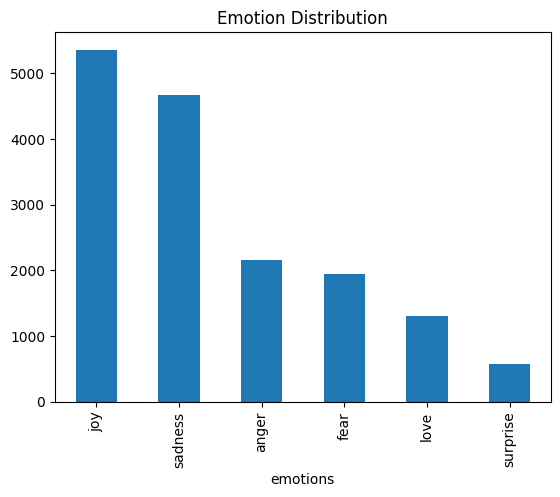

In [5]:
import matplotlib.pyplot as plt

train_df['emotions'].value_counts().plot(kind='bar', title="Emotion Distribution")
plt.show()

Text(0.5, 1.0, 'Text Lenght Distribution')

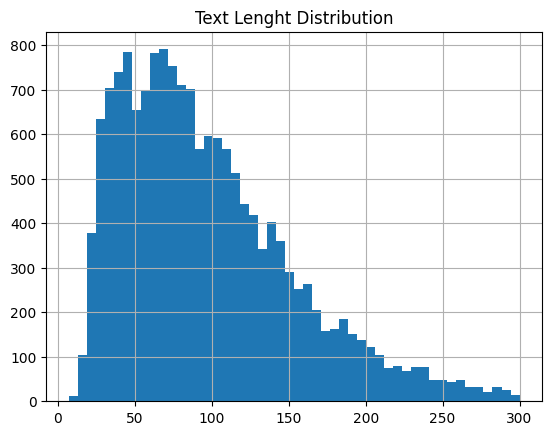

In [6]:
train_df['text_len'] = train_df['text'].apply(len)
train_df['text_len'].hist(bins=50)
plt.title('Text Lenght Distribution')

In [7]:
pip install transformers

In [8]:
from transformers import DistilBertTokenizerFast

In [9]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
#tokenize data:

train_enc = tokenizer(list(train_df['text']), truncation=True, padding=True, max_length=50)
test_enc = tokenizer(list(test_df['text']), truncation=True, padding=True, max_length=50)
val_enc = tokenizer(list(val_df['text']), truncation=True, padding=True, max_length=50)


In [11]:
pip install torch

In [12]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import torch

le=LabelEncoder()
y_train = le.fit_transform(train_df['emotions'])
y_val = le.transform(val_df['emotions'])
y_test = le.transform(test_df['emotions'])

In [13]:
class EmotionDataset(Dataset):
    def __init__(self,encodings,labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item



train_dataset = EmotionDataset(train_enc, y_train)
test_dataset = EmotionDataset(test_enc, y_test)
val_dataset = EmotionDataset(test_enc, y_test)


In [14]:
#Load and train model

from transformers import DistilBertForSequenceClassification

In [15]:
model= DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(le.classes_))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",        # where to save checkpoints
    eval_strategy="epoch",   # evaluate after each epoch
    save_strategy="epoch",         # save model each epoch
    learning_rate=2e-5,            # good default for BERT
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none" # Disable Weights & Biases logging
)

In [24]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds =logits.argmax(axis=1)
    return{
    "accuracy": accuracy_score(labels, preds),
    "f1": f1_score(labels, preds, average="weighted")
    }

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-2721217396.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.234000,0.224009,0.926000,0.927395
2,0.130000,0.192053,0.923500,0.923935
3,0.083100,0.217007,0.921500,0.921044


TrainOutput(global_step=3000, training_loss=0.14241955947875976, metrics={'train_runtime': 282.7031, 'train_samples_per_second': 169.789, 'train_steps_per_second': 10.612, 'total_flos': 620985225600000.0, 'train_loss': 0.14241955947875976, 'epoch': 3.0})

In [27]:
trainer.save_model("./emotion_model")
tokenizer.save_pretrained("./emotion_model")

('./emotion_model/tokenizer_config.json',
 './emotion_model/special_tokens_map.json',
 './emotion_model/vocab.txt',
 './emotion_model/added_tokens.json',
 './emotion_model/tokenizer.json')

In [31]:
from transformers import pipeline

clf = pipeline("text-classification", model="./emotion_model", tokenizer="./emotion_model")
print(clf("I am sad"))

Device set to use cuda:0


[{'label': 'LABEL_4', 'score': 0.9438797831535339}]


In [32]:
from transformers import pipeline

# Load your trained model and tokenizer
clf = pipeline("text-classification", model="./emotion_model", tokenizer="./emotion_model")

# Map LABEL_X to actual emotions (based on your training data)
label_map = {
    'LABEL_0': 'anger',
    'LABEL_1': 'fear',
    'LABEL_2': 'joy',
    'LABEL_3': 'love',
    'LABEL_4': 'sadness',
    'LABEL_5': 'surprise'
}

# Optional: Map emotions to small phrases
phrases = {
    'anger': "Take a deep breath, it’s okay to feel angry.",
    'fear': "It’s normal to be afraid, try to stay calm.",
    'joy': "Keep enjoying the moment!",
    'love': "Spread love and kindness.",
    'sadness': "It’s okay to feel sad sometimes.",
    'surprise': "Wow! That must be exciting!"
}

def predict_emotion(text, with_phrase=True):
    """
    Input: text string
    Output: prints predicted emotion, confidence, and optionally a phrase
    """
    result = clf(text)[0]  # get first dictionary from the pipeline output
    # Convert LABEL_X → emotion
    emotion = label_map[result['label']]
    confidence = result['score'] * 100  # convert to percentage

    print(f"Predicted emotion: {emotion} (Confidence: {confidence:.2f}%)")

    if with_phrase:
        print("Phrase:", phrases[emotion])

# Examples
predict_emotion("I am very angry")
predict_emotion("I feel so happy today!")
predict_emotion("I am a little scared about tomorrow")


Device set to use cuda:0


Predicted emotion: anger (Confidence: 99.87%)
Phrase: Take a deep breath, it’s okay to feel angry.
Predicted emotion: joy (Confidence: 99.96%)
Phrase: Keep enjoying the moment!
Predicted emotion: fear (Confidence: 99.88%)
Phrase: It’s normal to be afraid, try to stay calm.


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
!zip -r emotion_model.zip ./emotion_model

  adding: emotion_model/ (stored 0%)
  adding: emotion_model/model.safetensors (deflated 8%)
  adding: emotion_model/config.json (deflated 52%)
  adding: emotion_model/vocab.txt (deflated 53%)
  adding: emotion_model/training_args.bin (deflated 54%)
  adding: emotion_model/tokenizer_config.json (deflated 75%)
  adding: emotion_model/tokenizer.json (deflated 71%)
  adding: emotion_model/special_tokens_map.json (deflated 42%)
